# Vines

* install vine python package ``pyvinecopulib``

In [72]:
# !pip install pyvinecopulib

* import python libraries 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvinecopulib as pv
import seaborn as sns


* read the data file (Axle load of 4-axle vehicles in tons)

In [2]:
# datapath = r'C:\Users\mmendozalugo\OneDrive\PhD\Work\Side_tasks_works\Vines'
# four_axle_vehic = pd.read_csv(datapath+'\\WIM_A16L_four_axle_vehicles_sample_in_tons.csv')
four_axle_vehic = pd.read_csv('https://raw.githubusercontent.com/mike-mendoza/four_axle_vehicle_vine_example/main/WIM_A16L_four_axle_vehicles_sample_in_tons.csv')
four_axle_vehic.head()

,AX_W1,AX_W2,AX_W3,AX_W4
0,5.485,7.400,7.680,7.805
1,5.350,6.519,2.944,2.951
2,5.228,5.309,3.116,3.215
3,5.488,7.082,4.978,4.504
4,5.702,9.657,5.548,5.124


* scatter plot of data

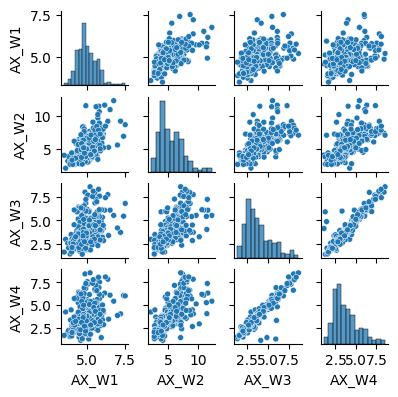

In [3]:
sns.pairplot(four_axle_vehic, height=1,plot_kws=dict(size=.1))
plt.show()

* transform to uniform (empirical margins)

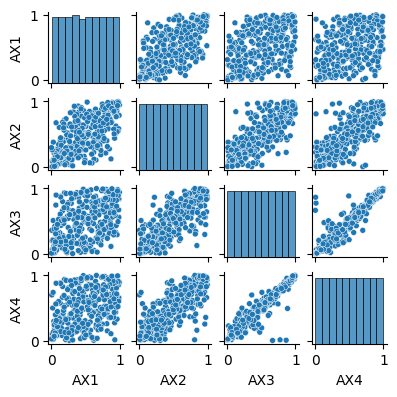

In [4]:
u = pv.to_pseudo_obs(four_axle_vehic) #library
#create a dataframe
uv = pd.DataFrame(data=u, columns=['AX1','AX2','AX3','AX4'])
sns.pairplot(uv, height=1,plot_kws=dict(size=.1))
plt.show()

* fit vine model

In [ ]:
controls = pv.FitControlsVinecop(family_set=[pv.BicopFamily.gaussian,pv.BicopFamily.clayton])
vine_model = pv.Vinecop(u, controls=controls)
print(vine_model)

In [77]:
#fit vine
vine_model = pv.Vinecop(u)
print(vine_model)

<pyvinecopulib.Vinecop>
** Tree: 0
1,2 <-> Gaussian, parameters = 0.670919
2,3 <-> Frank, parameters = 7.34537
3,4 <-> BB7, parameters = 5.13557
  1e-06
** Tree: 1
1,3 | 2 <-> TLL, parameters = [30x30 grid]
2,4 | 3 <-> Clayton, parameters = 0.18364
** Tree: 2
1,4 | 3,2 <-> Independence



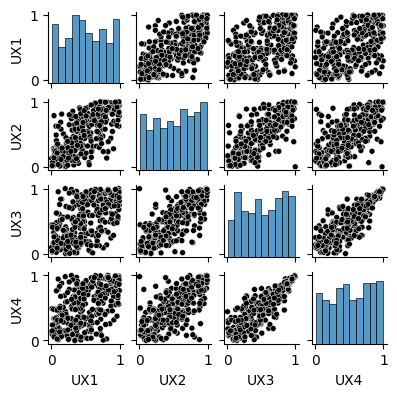

In [78]:
number_of_samples = len(uv)
uv_samples = vine_model.simulate( number_of_samples)
#create a dataframe
uvs = pd.DataFrame(data=uv_samples, columns=['UX1','UX2','UX3','UX4'])
sns.pairplot(uvs, height=1,plot_kws=dict(color='k', size=.1))
plt.show()

* fit the 24 regular vines (matrices)

In [79]:
# first we define a function to extract the matrices from a files
def get_matrices(file):
    mat = np.loadtxt(file,dtype=int)
    mat_idx = list(range(0,len(mat)+1,4))
    matrices = []
    for i in range(len(mat_idx)-1):
       matrices.append(mat[mat_idx[i]:mat_idx[i+1]])
    return matrices

#matrices file
file  = 'https://raw.githubusercontent.com/mike-mendoza/four_axle_vehicle_vine_example/main/submats_4_T4_T5.txt'
#get the matrices
matrices = get_matrices(file)

In [80]:
# Fitting the 24 regular vines (matrices) to data
rv = [pv.Vinecop(data=u, matrix=m) for m in matrices]


* Obtain AIC of all 24 fitted regular vines

In [81]:
akaike = [v.aic() for v in rv]

* Plot cumulative distribution of the 24 AIC values and the computed AIC by the algorithm

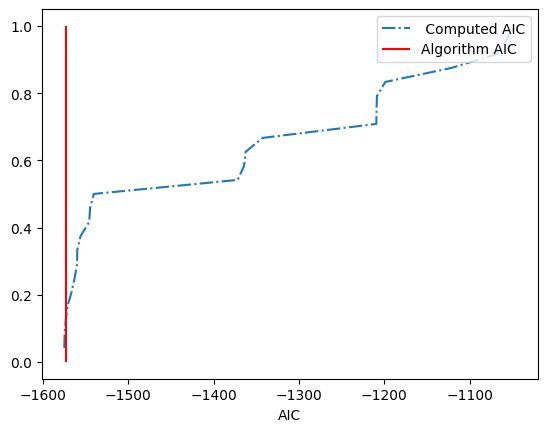

In [82]:
#first we define an ecdf function 
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

#compute the ecdf of the 24 AIC values
aic_ecdf = ecdf(akaike)
#get the AIC of the algorithm 
algo_aic = vine_model.aic() 
#plot the velues, the vertical line represent the AIC computed by the algorithm. 
plt.plot(aic_ecdf[0],aic_ecdf[1],'-.',label=' Computed AIC')
plt.vlines(algo_aic, 0,1, color='red', label= 'Algorithm AIC')
plt.xlabel('AIC')
plt.legend(loc=1)
plt.show()

* Get the regular vine with the lowest AIC

In [83]:
min_aic_index = akaike.index(min(akaike))
vine_min_aic = cop2[min_aic_index] #regular vine with the lowest AIC

print(vine_min_aic)

<pyvinecopulib.Vinecop>
** Tree: 0
1,4 <-> Gaussian, parameters = 0.407402
3,4 <-> BB7, parameters = 5.13553
  1e-06
4,2 <-> Frank, parameters = 7.26574
** Tree: 1
1,3 | 4 <-> TLL, parameters = [30x30 grid]
3,2 | 4 <-> Clayton, parameters = 0.30268
** Tree: 2
1,2 | 3,4 <-> BB1 180°, parameters = 0.13856
 1.5126



* Plot the uniform scatter matrix of the regular vine with the lowest AIC

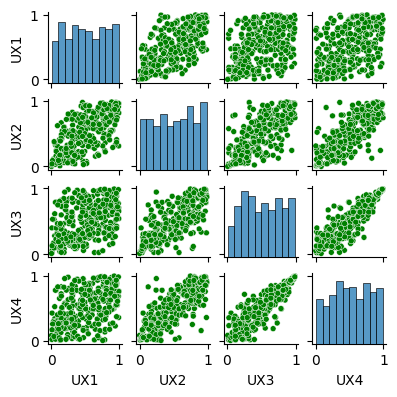

In [84]:
number_of_samples = len(uv)
uv_samples_vine_min = vine_min_aic.simulate(number_of_samples)
#create a dataframe
uvs_min_aic = pd.DataFrame(data=uv_samples_vine_min, columns=['UX1','UX2','UX3','UX4'])
sns.pairplot(uvs_min_aic, height=1,plot_kws=dict(color='green', size=.2))
plt.show()

* Compare models

Text(0.5, 1.1, 'Scatter matrix of the regular vine with the lowest AIC')

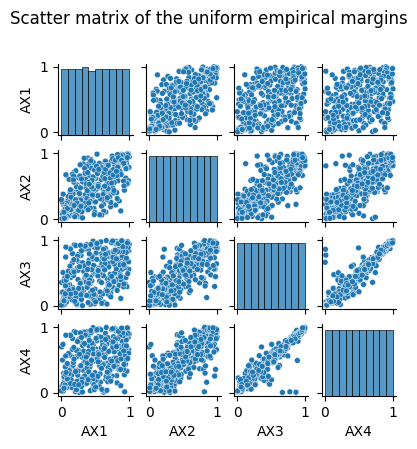

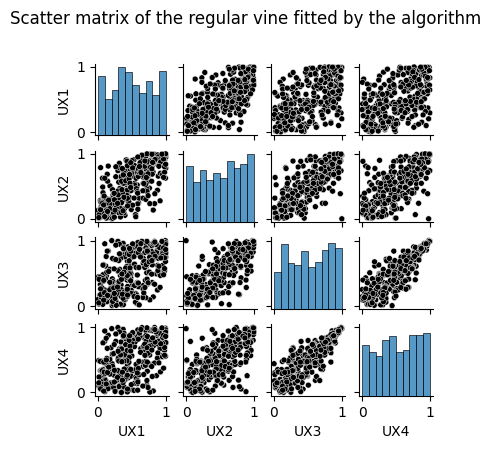

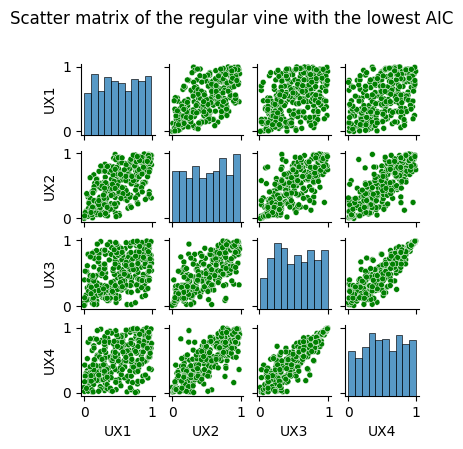

In [85]:
sp = sns.pairplot(uv, height=1,plot_kws=dict(size=.1))
sp.fig.suptitle('Scatter matrix of the uniform empirical margins',y=1.1)


sp2 = sns.pairplot(uvs, height=1,plot_kws=dict(color='k', size=.1))
sp2.fig.suptitle('Scatter matrix of the regular vine fitted by the algorithm',y=1.1)


sp3 = sns.pairplot(uvs_min_aic, height=1,plot_kws=dict(color='green', size=.2))
sp3.fig.suptitle('Scatter matrix of the regular vine with the lowest AIC',y=1.1)
